In [81]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
import utils

In [82]:
#Load data
train = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/train.json")
valid = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train_half/valid.json")
test = pd.read_json("/mnt/extDisk/courses/data/statoil/data/train/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
valid.inc_angle = valid.inc_angle.replace('na', 0)
valid.inc_angle = valid.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [83]:

# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Valid data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in valid["band_2"]])
X_valid = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_valid = np.array(valid.inc_angle)
y_valid = np.array(valid["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band2)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

In [86]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
model = utils.keras_baselilne()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_17 (Conv2D)               (None, 73, 73, 16)    448         X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_18 (Conv2D)               (None, 71, 71, 16)    2320        conv2d_17[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D)  (None, 35, 35, 16)    0           conv2d_18[0][0]                  
___________________________________________________________________________________________

In [23]:
batch_size=32
reload(utils)

#gen = ImageDataGenerator(vertical_flip = True)

#gen = ImageDataGenerator(zoom_range = 0.1)


#gen = ImageDataGenerator(horizontal_flip = True,
#                         vertical_flip = True,
#                         width_shift_range = 0.1,
#                         height_shift_range = 0.1,
#                         zoom_range = 0.1,
#                         rotation_range = 40)


# Finally create out generator
#gen_flow = utils.gen_flow_for_two_inputs(X_train, X_angle_train, y_train, gen)

#genX1 = gen.flow(X_train,y_train,  batch_size=32,seed=666)
gen_flow = utils.self_generator(X_train, X_angle_train, y_train, batch_size, method = 'black_box_gen')

In [24]:
file_path = "/mnt/extDisk/courses/data/statoil/data/data_aug/.model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=15)

model = utils.keras_baselilne()
model.fit_generator(gen_flow, validation_data=([X_valid, X_angle_valid], y_valid),
                    steps_per_epoch=len(X_train) / 32, epochs=40, callbacks=callbacks)

Epoch 1/40
18/18 [==============================] - 3s - loss: 0.9959 - acc: 0.4965 - val_loss: 0.7399 - val_acc: 0.5500
Epoch 2/40
18/18 [==============================] - 0s - loss: 0.9733 - acc: 0.5278 - val_loss: 0.6989 - val_acc: 0.5500
Epoch 3/40
18/18 [==============================] - 0s - loss: 0.8531 - acc: 0.5434 - val_loss: 0.6942 - val_acc: 0.5750
Epoch 4/40
18/18 [==============================] - 0s - loss: 0.8444 - acc: 0.5990 - val_loss: 0.7641 - val_acc: 0.6800
Epoch 5/40
18/18 [==============================] - 0s - loss: 0.9112 - acc: 0.5330 - val_loss: 0.5768 - val_acc: 0.6450
Epoch 6/40
18/18 [==============================] - 0s - loss: 0.7894 - acc: 0.5938 - val_loss: 0.6009 - val_acc: 0.6700
Epoch 7/40
18/18 [==============================] - 0s - loss: 0.7718 - acc: 0.5642 - val_loss: 0.5832 - val_acc: 0.6600
Epoch 8/40
18/18 [==============================] - 0s - loss: 0.7636 - acc: 0.5903 - val_loss: 0.5895 - val_acc: 0.6400
Epoch 9/40
18/18 [==============

In [25]:
optimizer = Adam(lr=0.00001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.load_weights(filepath=file_path)
model.fit_generator(gen_flow, validation_data=([X_valid, X_angle_valid], y_valid),
                    steps_per_epoch=len(X_train) / 32, epochs=40, callbacks=callbacks)

Epoch 1/40
18/18 [==============================] - 1s - loss: 0.5575 - acc: 0.7101 - val_loss: 0.5022 - val_acc: 0.7700
Epoch 2/40
18/18 [==============================] - 0s - loss: 0.5421 - acc: 0.7101 - val_loss: 0.4659 - val_acc: 0.8000
Epoch 3/40
18/18 [==============================] - 0s - loss: 0.5039 - acc: 0.7587 - val_loss: 0.4191 - val_acc: 0.7900
Epoch 4/40
18/18 [==============================] - 0s - loss: 0.5339 - acc: 0.7465 - val_loss: 0.4247 - val_acc: 0.8200
Epoch 5/40
18/18 [==============================] - 0s - loss: 0.5464 - acc: 0.7153 - val_loss: 0.5024 - val_acc: 0.7650
Epoch 6/40
18/18 [==============================] - 0s - loss: 0.5451 - acc: 0.7118 - val_loss: 0.4607 - val_acc: 0.8000
Epoch 7/40
18/18 [==============================] - 0s - loss: 0.5569 - acc: 0.7031 - val_loss: 0.4627 - val_acc: 0.7900
Epoch 8/40
18/18 [==============================] - 0s - loss: 0.5859 - acc: 0.7066 - val_loss: 0.5062 - val_acc: 0.7750
Epoch 9/40
18/18 [==============

In [256]:
reload(utils)
mean = np.mean(X_train.reshape(3,602,75,75))
std = np.std(X_train.reshape(3,602,75,75))
X_train_final, X_angle_train_final, y_train_final = utils.flip(X_train,X_angle_train,y_train)

In [269]:
file_path = "/mnt/extDisk/courses/data/statoil/data/data_aug/.model_weights_temp.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=7)

reload(utils)
model = utils.keras_baselilne()
model.fit([X_train_final,X_angle_train_final], y_train_final, epochs=15
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=64
         , callbacks=callbacks)

Train on 2408 samples, validate on 200 samples
Epoch 1/15
2408/2408 [==============================] - 34s - loss: 0.7586 - acc: 0.6424 - val_loss: 0.5467 - val_acc: 0.7600
Epoch 2/15
2408/2408 [==============================] - 1s - loss: 0.5824 - acc: 0.7218 - val_loss: 0.6573 - val_acc: 0.7250
Epoch 3/15
2408/2408 [==============================] - 1s - loss: 0.4769 - acc: 0.7770 - val_loss: 0.3474 - val_acc: 0.8300
Epoch 4/15
2408/2408 [==============================] - 1s - loss: 0.4069 - acc: 0.8127 - val_loss: 0.3337 - val_acc: 0.8350
Epoch 5/15
2408/2408 [==============================] - 1s - loss: 0.3403 - acc: 0.8472 - val_loss: 0.6462 - val_acc: 0.7550
Epoch 6/15
2408/2408 [==============================] - 1s - loss: 0.3434 - acc: 0.8434 - val_loss: 0.2591 - val_acc: 0.9050
Epoch 7/15
2408/2408 [==============================] - 1s - loss: 0.3316 - acc: 0.8459 - val_loss: 0.2467 - val_acc: 0.8850
Epoch 8/15
2408/2408 [==============================] - 1s - loss: 0.3063 - a

In [270]:
optimizer = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.load_weights(filepath=file_path)
model.fit([X_train,X_angle_train], y_train, epochs=15
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 602 samples, validate on 200 samples
Epoch 1/15
602/602 [==============================] - 10s - loss: 0.2569 - acc: 0.8837 - val_loss: 0.3810 - val_acc: 0.8450
Epoch 2/15
602/602 [==============================] - 0s - loss: 0.2532 - acc: 0.8738 - val_loss: 0.2794 - val_acc: 0.8900
Epoch 3/15
602/602 [==============================] - 0s - loss: 0.2585 - acc: 0.8904 - val_loss: 0.2065 - val_acc: 0.9250
Epoch 4/15
602/602 [==============================] - 0s - loss: 0.2546 - acc: 0.8704 - val_loss: 0.2512 - val_acc: 0.9100
Epoch 5/15
602/602 [==============================] - 0s - loss: 0.2501 - acc: 0.8804 - val_loss: 0.2419 - val_acc: 0.9050
Epoch 6/15
602/602 [==============================] - 0s - loss: 0.2555 - acc: 0.8754 - val_loss: 0.2065 - val_acc: 0.9250
Epoch 7/15
602/602 [==============================] - 0s - loss: 0.2507 - acc: 0.8721 - val_loss: 0.2985 - val_acc: 0.8950
Epoch 8/15
602/602 [==============================] - 0s - loss: 0.2330 - acc: 0.8904 - val_

In [271]:
optimizer = Adam(lr=0.00001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.load_weights(filepath=file_path)
model.fit([X_train,X_angle_train], y_train, epochs=15
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 602 samples, validate on 200 samples
Epoch 1/15
602/602 [==============================] - 10s - loss: 0.2717 - acc: 0.8771 - val_loss: 0.1949 - val_acc: 0.9300
Epoch 2/15
602/602 [==============================] - 0s - loss: 0.2565 - acc: 0.8854 - val_loss: 0.2433 - val_acc: 0.8950
Epoch 3/15
602/602 [==============================] - 0s - loss: 0.2647 - acc: 0.8787 - val_loss: 0.2134 - val_acc: 0.9200
Epoch 4/15
602/602 [==============================] - 0s - loss: 0.2781 - acc: 0.8738 - val_loss: 0.1969 - val_acc: 0.9400
Epoch 5/15
602/602 [==============================] - 0s - loss: 0.2625 - acc: 0.8721 - val_loss: 0.2971 - val_acc: 0.8800
Epoch 6/15
602/602 [==============================] - 0s - loss: 0.2168 - acc: 0.9037 - val_loss: 0.2628 - val_acc: 0.8900
Epoch 7/15
602/602 [==============================] - 0s - loss: 0.2430 - acc: 0.8854 - val_loss: 0.2292 - val_acc: 0.9150
Epoch 8/15
602/602 [==============================] - 0s - loss: 0.2580 - acc: 0.8920 - val_

In [272]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
600/602 [============================>.] - ETA: 0s[0.19953748237255009, 0.91029904767920411]
####################
watch list evaluate:
200/200 [==============================] - 0s
[0.18008846044540405, 0.9450000524520874]


In [273]:
valid_prediction = model.predict([X_valid, X_angle_valid], verbose=1, batch_size=200)

200/200 [==============================] - 7s


In [274]:
vaild_df = valid
vaild_df['prediction'] = valid_prediction

utils.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  layer_dense = Dense(256)(layer_dense)


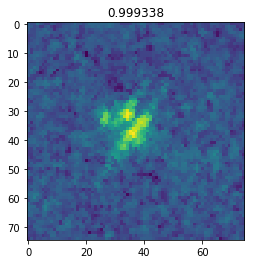

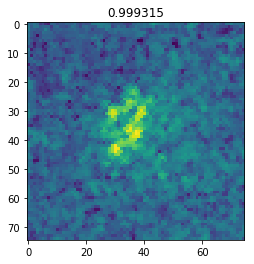

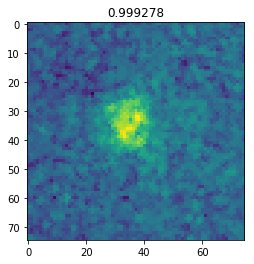

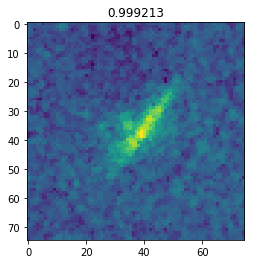

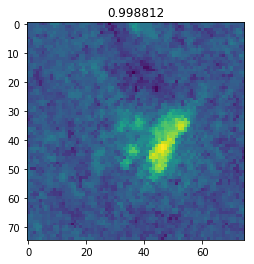

In [275]:
reload(utils)
utils.true_positive(vaild_df)

utils.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return model


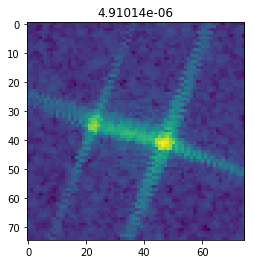

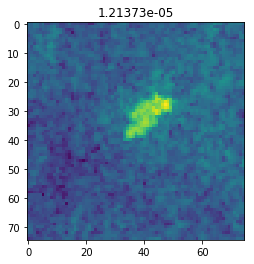

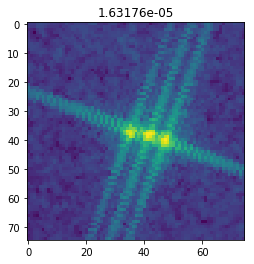

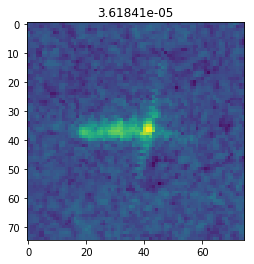

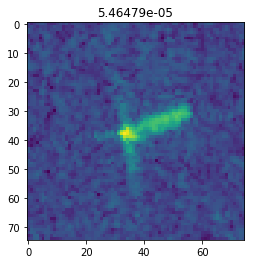

In [276]:
reload(utils)
utils.true_negetive(vaild_df)

utils.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  def true_negetive(valid):


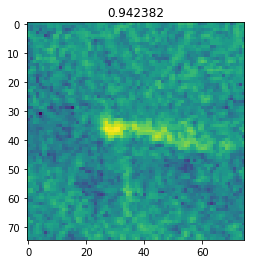

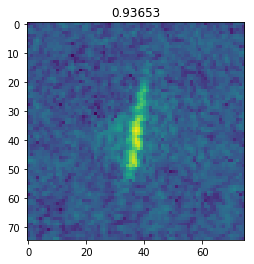

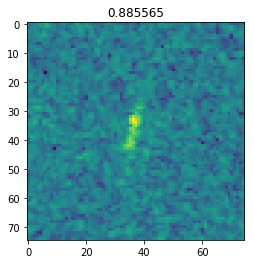

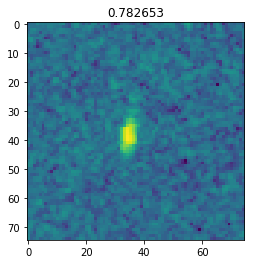

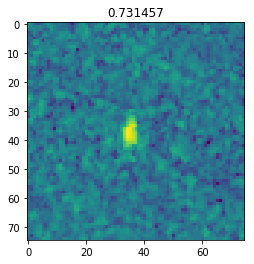

In [277]:
reload(utils)
utils.false_positive(vaild_df)

utils.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  def true_positive(valid):


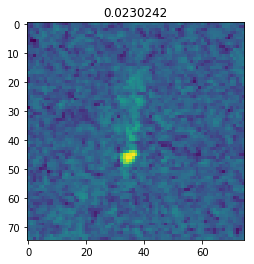

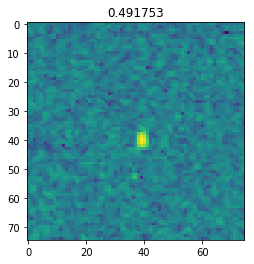

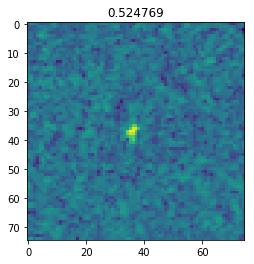

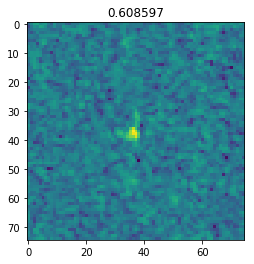

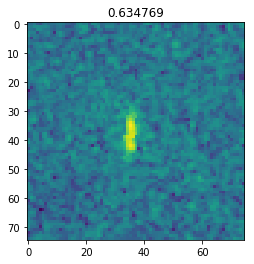

In [278]:
reload(utils)
utils.false_negative(vaild_df)

In [279]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8200/8424 [============================>.] - ETA: 0s

In [280]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.010108
1,4023181e,0.015457
2,b20200e4,0.000367
3,e7f018bb,0.985180
4,4371c8c3,0.044416
5,a8d9b1fd,0.898858
6,29e7727e,0.082567
7,92a51ffb,0.984015
8,c769ac97,0.002713
9,aee0547d,0.000307


In [281]:
submission.to_csv("/mnt/extDisk/courses/data/statoil/data/data_aug/fliping_3_arch.csv", index=False)

In [23]:
X_train_final.shape

(4214, 75, 75, 3)

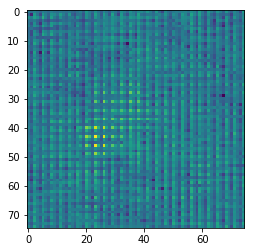

In [195]:
import matplotlib.pyplot as plt
plt.imshow((X_train_final[4 +3*602]).reshape(3,75,75)[1])
plt.show()

In [105]:
X_train_final[1200].reshape(3,75,75)[2][0][0]

-24.436655166970592

In [119]:
(X_train_final[1 +1*602]).reshape(3,75,75)[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [20]:
#np.mean((X_train[1 +0*602]).reshape(3,75,75)[0])
for image in X_train:
    if np.mean(image.reshape(3,75,75)[1]) > np.mean(image.reshape(3,75,75)[0]):
        print 'valens'

valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens
valens

In [25]:
np.mean([np.mean(image.reshape(3,75,75)[0]) for image in X_train])/np.mean([np.mean(image.reshape(3,75,75)[1]) for image in X_train])

1.0420145

In [31]:
np.mean([X_train[0].reshape(3,75,75)[0][0][0],X_train[0].reshape(3,75,75)[1][0][0]]).reshape(3,75,75)

ValueError: cannot reshape array of size 1 into shape (3,75,75)